# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
"""NIHCXR Clinical Drift Experiments Tutorial."""

from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device


device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender",
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True,
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 78828.99 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 103868.33 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 123460.63 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 135768.17 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 143430.22 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 149472.64 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 120393.27 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 79816.94 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 111283.83 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 133279.25 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 145177.56 examples/s]

Filter (num_proc=6):  83%|████████▎ | 92748/112120 [00:00<00:00, 139735.19 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 126433.30 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.37 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.58 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.40 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 14.75 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 14.65 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.98 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.08 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.54 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.58 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.02 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.39 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 21.44 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.69 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.55 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.18 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.09 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.03 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.30 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.20 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.42 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.24 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 17.02 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.83 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.26 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.39 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.46 examples/s]

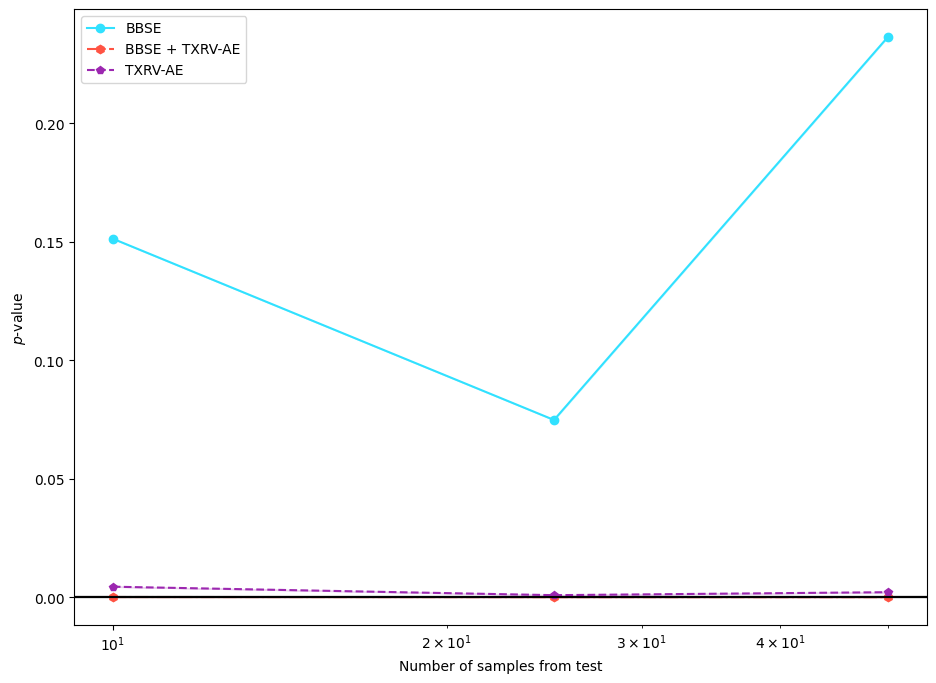

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.20 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.38 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.46 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.35 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.37 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.31 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.40 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.47 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.33 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.49 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.36 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.66 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.35 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.88 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.06 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.90 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.31 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.18 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.50 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.44 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 21.93 examples/s]

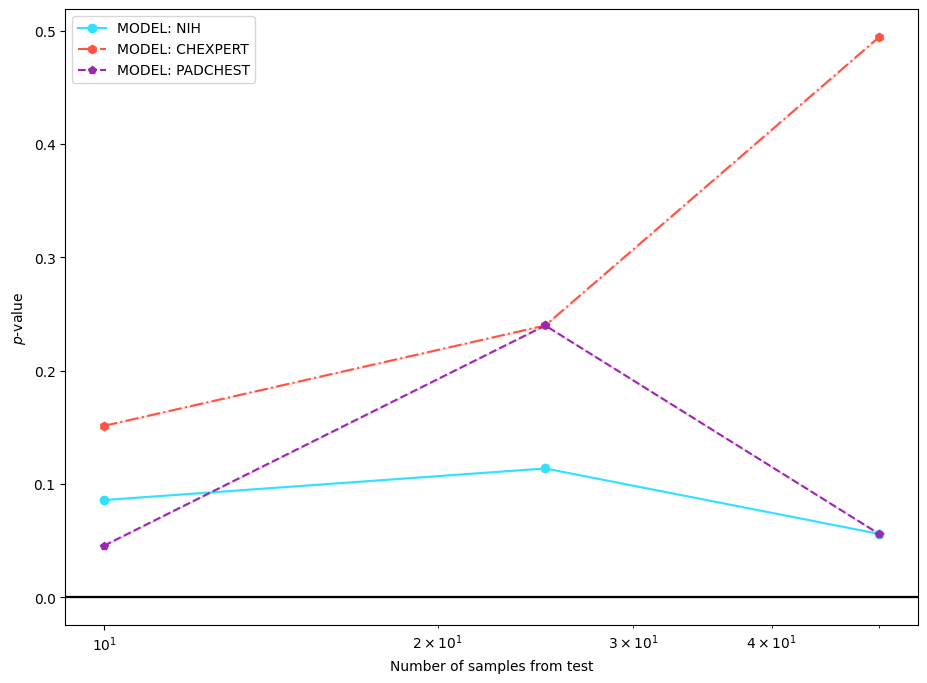

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device,
        ),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 59161.92 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79917.33 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93790.03 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98734.79 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100859.56 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 107035.44 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 87508.47 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):   8%|▊         | 9000/112120 [00:00<00:04, 21219.39 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73603.77 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90697.52 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100037.94 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 105200.72 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110874.60 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 83666.94 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.42 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.27 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.39 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.26 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.31 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.25 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.52 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.48 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 57455.17 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79940.52 examples/s]

Filter (num_proc=6):  48%|████▊     | 54374/112120 [00:00<00:00, 86525.81 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99902.41 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 99836.75 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109184.43 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 87060.37 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 58057.15 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 82058.83 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 97905.34 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 105105.88 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 105960.60 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109920.15 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 89500.40 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.31 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.13 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.04 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.75 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.62 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.73 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.66 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.89 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.62 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55782.96 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77029.40 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94893.46 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102367.62 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106749.47 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108783.98 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 87874.05 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55185.37 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79701.70 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90868.93 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102844.47 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 108017.24 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 116144.41 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 90572.81 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.88 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.62 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.42 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 15.82 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 15.77 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.59 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.65 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.52 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 58022.13 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81600.04 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 98055.53 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 106984.00 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 109847.13 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 113026.98 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 91248.74 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 57155.27 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81242.73 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93789.31 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100530.39 examples/s]

Filter (num_proc=6):  81%|████████  | 90748/112120 [00:01<00:00, 93339.79 examples/s] 

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111455.08 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 87739.50 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.86 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.23 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.01 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.69 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.56 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.44 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.38 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.87 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.69 examples/s]

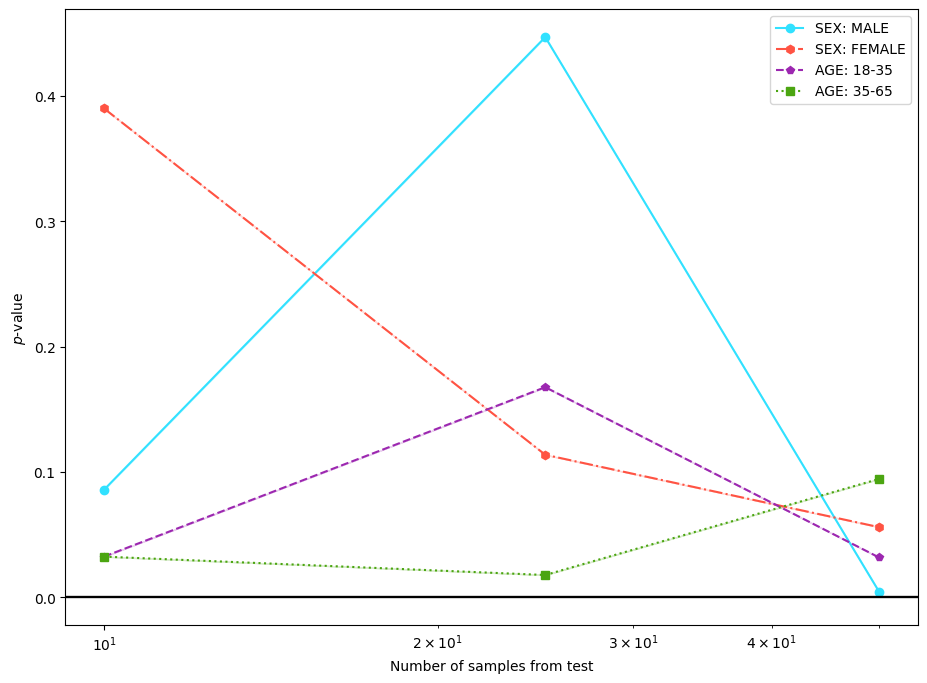

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}],
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}],
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice,
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.18 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.01 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.47 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.32 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.94 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.80 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.44 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.29 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.40 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.26 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.39 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.24 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.30 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.16 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.70 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.55 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.94 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.81 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.64 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.49 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.50 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.35 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.28 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.13 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.68 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.54 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.70 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.54 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.86 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.71 examples/s]

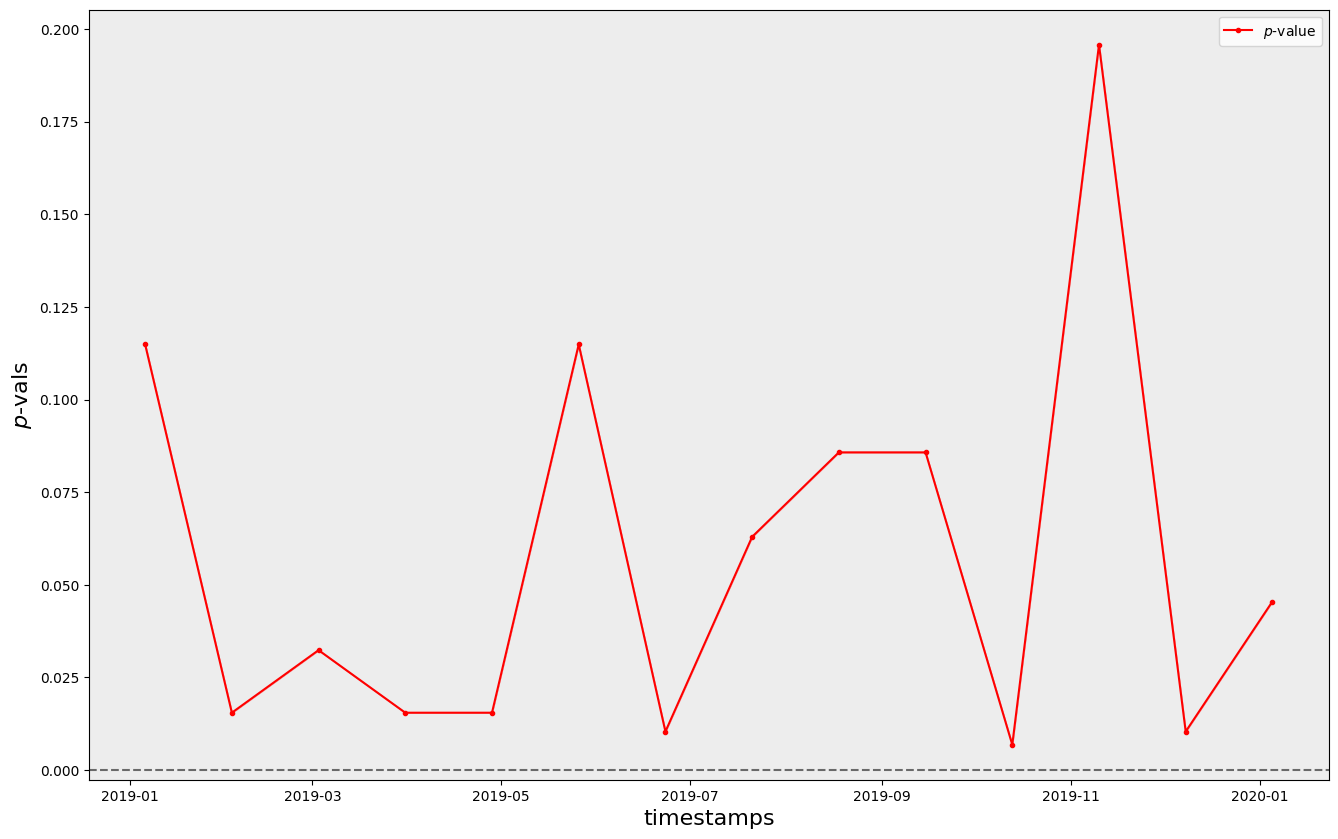

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="ks"),
    source_sample_size=50,
    target_sample_size=10,
    timestamp_column="timestamp",
    window_size="4W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)